https://machinelearningmastery.com/lstm-autoencoders/

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

https://towardsdatascience.com/lstm-autoencoder-for-extreme-rare-event-classification-in-keras-ce209a224cfb

https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352

In [9]:
#from google.colab import drive
#drive.mount('/content/drive')

1. MinMax scalar
2. Different loss functions
3. How to take output of encoder part

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

In [11]:
plt.rcParams["figure.figsize"] = [16,9]

In [12]:
# _initializing constant variables
#input_file_path = os.getcwd() + f'/../data/output_csv/processed_data.csv'
input_file_path = f'processed_data_train.csv'
col_names = ['subject_id', 'activityID', 'X1', 'Y1', 'Z1', 'X2', 'Y2', 'Z2']
main_df = pd.read_csv(input_file_path, names=col_names)

1 WALKING

2 WALKING_UPSTAIRS

3 WALKING_DOWNSTAIRS

4 SITTING

5 STANDING

6 LAYING


In [13]:
main_df

,subject_id,activityID,X1,Y1,Z1,X2,Y2,Z2
0,1.0,5.0,1.012817,-0.123217,0.102934,0.030191,0.066014,0.022859
1,1.0,5.0,1.022833,-0.126876,0.105687,0.043711,0.042699,0.010316
2,1.0,5.0,1.022028,-0.124004,0.102102,0.035688,0.074850,0.013250
3,1.0,5.0,1.017877,-0.124928,0.106553,0.040402,0.057320,0.017751
4,1.0,5.0,1.023680,-0.125767,0.102814,0.047097,0.052343,0.002553
...,...,...,...,...,...,...,...,...
941051,7352.0,2.0,0.991497,-0.486260,-0.205803,0.973228,1.083094,-0.226884
941052,7352.0,2.0,0.945067,-0.453405,-0.180733,1.004266,1.187832,-0.313591
941053,7352.0,2.0,0.898095,-0.397775,-0.156105,1.004855,1.156645,-0.362512
941054,7352.0,2.0,0.828372,-0.349247,-0.122798,1.015589,1.100750,-0.383989


In [14]:
main_df.sort_values(by=['activityID'], inplace=True)
main_df[['subject_id','activityID']].groupby(['activityID']).agg(['count'])

,subject_id
,count
activityID,
1.0,156928
2.0,137344
3.0,126208
4.0,164608
5.0,175872
6.0,180096


In [15]:
#drop_cols = ['subject_id']
#main_df.drop(columns=drop_cols, axis=1, inplace=True)
subjects = set(list(main_df.subject_id.unique()))
print(len(subjects))

7352


In [16]:
main_df.shape

(941056, 8)

In [17]:
window_size = 16
window_overlap = 8
timesteps = window_size
max_window_index = 128
features = 6
output_filename = f'UCIHAR_sensor_features_lstm_tuned_train_{16}.csv'
output_filename

'UCIHAR_sensor_features_lstm_tuned_train_16.csv'

In [18]:
sensor_data = main_df.iloc[:, 2:].values.astype('float32')
print(sensor_data.shape)

(941056, 6)


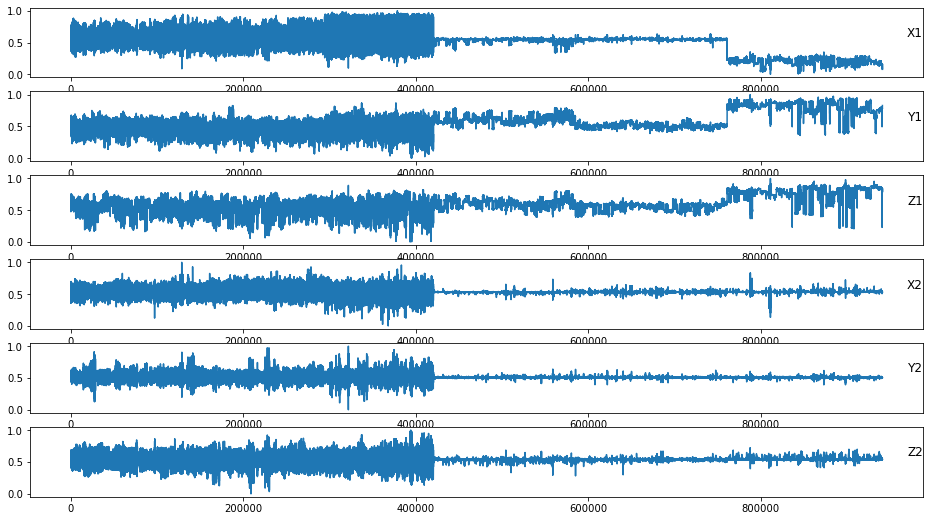

In [19]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

for idx in range(features):
    sensor_data[:, idx] = MinMaxScaler().fit_transform(sensor_data[:, idx].reshape(-1, 1)).reshape(1,-1)

plt.figure()
for col in range(features):
	plt.subplot(features, 1, col+1)
	plt.plot(sensor_data[:, col])
	plt.title(col_names[col+2], y=0.5, loc='right')

plt.show()

In [20]:
def get_window_data(instance_data):

  instance_data = instance_data.reshape(6, 128)
  window_index = 0
  sub_sequences = [[] for i in range(6)]

  while window_index <= (max_window_index - window_size):

      for idx in range(6):
          sub_sequences[idx].append(instance_data[idx][window_index:window_index+window_size].tolist())

      window_index += window_overlap

  sub_sequences = np.array(sub_sequences).reshape(-1, 6, 16)
  return sub_sequences

In [21]:
activity_subject_df = main_df[['activityID', 'subject_id']].drop_duplicates().values.astype('int32')
activity_sequences = []
sensor_sequences = np.array([])

for instance in activity_subject_df:
  activity = instance[0]
  subject = instance[1]
  instance_data = main_df.loc[(main_df['subject_id'] == subject) & (main_df['activityID'] == activity)]
  subsequence_data = get_window_data(instance_data[col_names[2:]].values)

  for val in range(subsequence_data.shape[0]):
    activity_sequences.append([subject, activity])

  if sensor_sequences.size == 0:
    sensor_sequences = subsequence_data
  else:
    sensor_sequences = np.vstack((sensor_sequences, subsequence_data))  

In [22]:
assert len(activity_sequences) == sensor_sequences.shape[0]
sensor_sequences.shape

In [24]:
# _input data format - [samples, timesteps, features]
features = 1
sensor_data = sensor_sequences[:, 0]
sensor_data = sensor_data.reshape(-1, timesteps, features)

for col in range(1, 6):
  sensor_data_channel = sensor_sequences[:, col]
  sensor_data_channel = sensor_data_channel.reshape(-1, timesteps, features)

  sensor_data = np.vstack((sensor_data, sensor_data_channel))  
  
sensor_data.shape

(661680, 16, 1)

In [20]:
def build_model(hp):

    lstm_layer_1_output_params = hp.Int(
        'output_1', min_value=80, max_value=120, step=5)
    lstm_layer_2_output_params = hp.Int(
        'output_2', min_value=50, max_value=80, step=5)
    
    lstm_layer_1_dropoutrate_params = hp.Float(
        'dropoutrate_1', min_value=0.2, max_value=0.6, step=0.1)
    lstm_layer_2_dropoutrate_params = hp.Float(
        'dropoutrate_2', min_value=0.2, max_value=0.6, step=0.1)

    activation_fn_params = hp.Choice(
        'act_fn', values=['relu', 'tanh'])

    learning_rate_params = hp.Choice(
        'learning_rate', values=[1e-2, 1e-3])

    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(lstm_layer_1_output_params, activation=activation_fn_params, input_shape=(timesteps, features), return_sequences=True),
        tf.keras.layers.LSTM(lstm_layer_2_output_params, activation=activation_fn_params, return_sequences=False),
        tf.keras.layers.Dropout(rate=lstm_layer_1_dropoutrate_params),

        tf.keras.layers.RepeatVector(timesteps),

        tf.keras.layers.LSTM(lstm_layer_2_output_params, activation=activation_fn_params, return_sequences=True),
        tf.keras.layers.LSTM(lstm_layer_1_output_params, activation=activation_fn_params, return_sequences=True),
        tf.keras.layers.Dropout(rate=lstm_layer_2_dropoutrate_params),

        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(features))    
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_params),loss='mse')

    return model

In [21]:
tuner_bo = kt.tuners.BayesianOptimization(
                build_model,objective=kt.Objective('val_loss', direction="min"), max_trials = 10, executions_per_trial=2
)

# tuner_bo.search(sensor_data, sensor_data, epochs=3, batch_size=64 ,validation_split=0.3)
# best_model = tuner_bo.get_best_models(num_models=1)[0]
# print(best_model.summary()) 

# best_hp = tuner_bo.get_best_hyperparameters()[0]
# print(best_hp.values)

In [22]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.001, 
    patience=10, 
    restore_best_weights=True,
)

#history = best_model.fit(sensor_data, sensor_data, epochs=50, validation_split=0.4, callbacks=[early_stopping], batch_size=32)

In [25]:
lstm_ae_model = tf.keras.models.Sequential([
     tf.keras.layers.LSTM(100, activation='tanh', input_shape=(timesteps, features), return_sequences=True),
     tf.keras.layers.LSTM(60, activation='tanh', return_sequences=False),
     tf.keras.layers.Dropout(rate=0.2),

     tf.keras.layers.RepeatVector(timesteps),

     tf.keras.layers.LSTM(60, activation='tanh', return_sequences=True),
     tf.keras.layers.LSTM(100, activation='tanh', return_sequences=True),
     tf.keras.layers.Dropout(rate=0.5),

     tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(features))    
 ])
lstm_ae_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
lstm_ae_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16, 100)           40800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 60)                38640     
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 16, 60)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 16, 60)            29040     
_________________________________________________________________
lstm_3 (LSTM)                (None, 16, 100)           64400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 100)           0

In [29]:
early_stopping = tf.keras.callbacks.EarlyStopping(
     min_delta=0.001, 
     patience=5, 
     restore_best_weights=True,
 )

history = lstm_ae_model.fit(sensor_data, sensor_data, epochs=50, validation_split=0.4, callbacks=[early_stopping],shuffle=True, batch_size=64)
best_model = lstm_ae_model

Train on 397008 samples, validate on 264672 samples
Epoch 1/50
155776/397008 [==========>...................] - ETA: 11:28 - loss: 0.1112WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss


KeyboardInterrupt: 

INFO:tensorflow:Assets written to: channel_independent/assets


INFO:tensorflow:Assets written to: channel_independent/assets


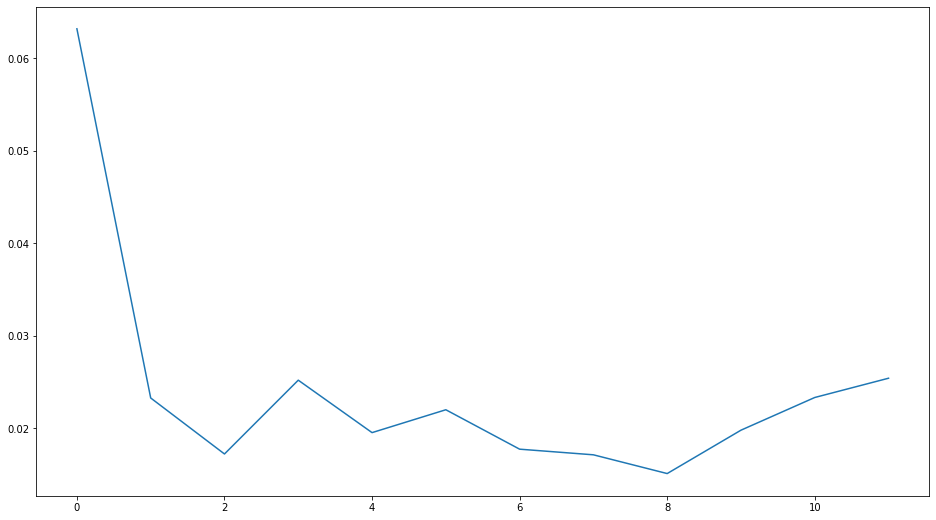

In [25]:
lstm_ae_model.save('channel_independent.h5')
plt.plot(history.history['loss'])
plt.show()

In [26]:
sensor_data.shape

(661680, 16, 1)

In [28]:
best_model = tf.keras.models.load_model('channel_independent/') 

TypeError: The added layer must be an instance of class Layer. Found: <tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7fae10020710>

In [30]:
get_2rd_layer_output = tf.keras.backend.function([best_model.layers[0].input],
                                  [best_model.layers[2].output])

In [ ]:
encoder_output = get_2rd_layer_output(sensor_data)

In [28]:
get_2rd_layer_output = tf.keras.backend.function([best_model.layers[0].input],
                                  [best_model.layers[1].output])
encoder_output = get_2rd_layer_output(sensor_data)
sensor_features = np.asarray(encoder_output).astype('float32')
print(sensor_features.shape)
sensor_features = sensor_features.reshape(sensor_features.shape[1], sensor_features.shape[2])
sensor_features.shape

InternalError: ignored

In [ ]:
final_data = np.append(act_sub_data, sensor_features, axis=1)
final_data.shape

In [ ]:
np.savetxt(output_filename, final_data, delimiter=",")